In [1]:
# Load Datasets
import os
import datetime
import numpy as np
import torch as th
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
sys.path.append("../classifier/")
from model.data import CGDataset, VectorCGDataset, NeighbourCGDataset
from model.model import DiffCG, MinCutCG, DMoNCG, DeepCG
from run.train import training
from run.test import test


print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cpu") #("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 0

dataset_dict = {c.__name__: c for c in {CGDataset, VectorCGDataset, NeighbourCGDataset}}

if vectorize:
    dataset_v = "VectorCGDataset"
elif k > 0:
    dataset_v = "NeighbourCGDataset"
else:
    dataset_v = "CGDataset"

#Training Set
training_dir = "../data/train_set"
rmsd_list = "../data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = dataset_dict[dataset_v](training_dir, rmsd_list, k=k)# T.NormalizeScale()) #, transform=transform_fn

#Validation Set
val_dir = "../data/val_set"
val_rmsd = "../data/val_rmsd_list.txt"
val_dataset = dataset_dict[dataset_v](val_dir, val_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

#Test Data
test_dir = "../data/test_set"
test_rmsd = "../data/test_rmsd_list.txt"
test_dataset = dataset_dict[dataset_v](test_dir, test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "../data/old_training_set"
st_test_rmsd = "../data/old_train_rmsd_list.txt"
st_test_dataset = dataset_dict[dataset_v](st_test_dir, st_test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

#Rotated Test Sets
test_dir_rot = "../data/test_set_rot"
test_rmsd = "../data/test_rmsd_list.txt"
rot_test_dataset = dataset_dict[dataset_v](test_dir_rot, test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

fst_test_rot = "../data/5st_test_rot"
fst_rot_dataset = dataset_dict[dataset_v](fst_test_rot, st_test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

Pytorch Version 1.11.0
Cuda is available: True
Using device: cpu


TODO:
*  Should Vector and Neighbour datasets inherit from CGDataset, to avoid code duplication?
*  Add further that start of s1 is in yz-plane with s0 **Semi-DONE** (theres still a range of angles)
*  are there additional tertiary interactions detected to add?
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  try skip-cat/-sum in layer architecture?
    * use the module `JumpingKnowledge` in PyG

Normalization:
*  BatchNorm: no improvement seen, maybe with larger datasets?
*  PairNorm: Training took longer, results were nonsense
*  DiffGroupNorm: figure out how to configure it (in channels not the same as for the layers)
*  GraphNorm: Strange results, try again. (maybe with GINConv layers, as is shown in the paper?), doesnt seem to work in this case (at least with normal data)
*  LayerNorm: Training took longer, results were worse than without norm
*  InstanceNorm: doesnt work for 3D input? --> try pytorch instancenorm1(?)d instead of pygs

--> try data normalization/standardization (beforehand)

In [11]:
#model = MinCutCG(training_dataset.num_node_features)
model = DeepCG(training_dataset.num_node_features, [3, 8, 36, 3])

12.07.2022 14:29:12 Creating Training Directory at ../run_data/2022-07-12_14-29_DeepCG/
12.07.2022 14:29:12 Loading Datasets
12.07.2022 14:29:12 Start Training


Epoch 0: Training loss 16.9638; Validation loss 21.9579, MAE: 22.3975; lr: 0.00100
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 5: Training loss 15.7899; Validation loss 20.3813, MAE: 20.8762; lr: 0.00100
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 10: Training loss 5.5941; Validation loss 13.4729, MAE: 13.9653; lr: 0.00100
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 15: Training loss 3.6297; Validation loss 13.1721, MAE: 13.6648; lr: 0.00100
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 20: Training loss 3.6084; Validation loss 13.7564, MAE: 14.2449; lr: 0.00100
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 25: Training loss 2.8203; Validation loss 13.5463, MAE: 14.0394; lr: 0.00100
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 30: Training loss 2.5468; Validation loss 12.3525, MAE: 12.8480; lr: 0.00100
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 35: Training loss 2.3562; Validation loss 13.2203, MAE: 13.7153; lr: 0.00100
	Add. L

12.07.2022 14:55:46 Training took 0.44 hours
12.07.2022 14:55:46 Minimum Training Loss 0.1713 in epoch 487
12.07.2022 14:55:46 Minimum Validation Loss (after 0 epochs) 11.7825 in epoch 468
12.07.2022 14:55:46 Minimum MAE (after 0 epochs) 12.2774 in epoch 468
12.07.2022 14:55:46 Seed used for training was: 5852283016853924042


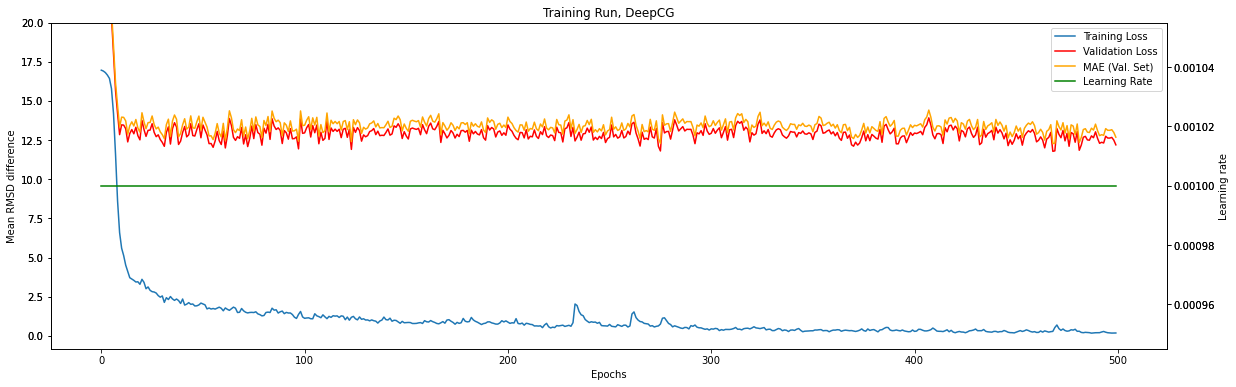

In [12]:
#Training
parent_dir = "../run_data/"

#with th.autograd.detect_anomaly():
training(
    model=model,
    train_dataset=training_dataset,
    val_dataset=val_dataset,
    model_dir=parent_dir,
    device=device,
    b_size=64,
    lr=1e-3,
    epochs=500,
    sched_T0=0,
    vectorize=vectorize,
    k=k,
    #num_workers=0,
    #resume="../run_data/2022-07-04_10-2_MinCutCG/model_data/epoch_1999.pth",
    burn_in=0)

In [13]:
#get training run data

run_dir = "../run_data/2022-07-12_14-29_DeepCG"#"/scr/risa/mgeyer/GCN/run_data/2022-07-08_12-48_MinCutCG"#
burn_in = 50

file_lines = []
with open(run_dir + "/loss_data.txt", "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]
epoch_add_losses = [float(d) for d in file_lines[4]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after {burn_in} epochs) {min(val_losses[burn_in:]):.4f} in epoch {val_losses.index(min(val_losses[burn_in:]))}")
print(f"Minimum MAE (after {burn_in} epochs) {min(mae_losses[burn_in:]):.4f} in epoch {mae_losses.index(min(mae_losses[burn_in:]))}")


Minimum Training Loss 0.1713 in epoch 487
Minimum Validation Loss (after 50 epochs) 11.7825 in epoch 468
Minimum MAE (after 50 epochs) 12.2774 in epoch 468


Validation Loss at 468 is 11.7825
5 before select
12.5002, 12.0047, 12.5669, 12.6723, 12.9936
5 after select
11.8111, 13.2369, 12.8672, 12.6508, 13.1158
MAE at 468 is 12.2774


/tmp/ipykernel_55939/1794408531.py:31: UserWarning: Attempting to set identical bottom == top == 0.001 results in singular transformations; automatically expanding.
  ax2.set_ylim([(min(learning_rates)), max(learning_rates)])


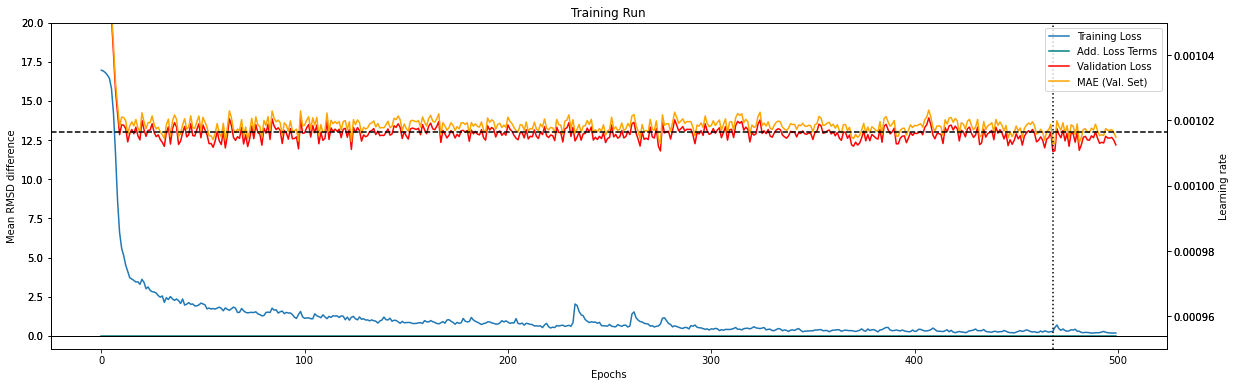

In [14]:
#plot the training run
select = 468

print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(figsize=(20, 6))#layout="constrained", 
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(epoch_add_losses, "teal", label="Add. Loss Terms")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")

ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
#ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")

ax1.set_ylim([(min(epoch_losses)-1), 20]) #max(val_losses)+2)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=0.0, linewidth=1, c = "black")#, ls = "--")
ax1.axhline(y=13, c = "black", ls = "--")

ax2.set_ylim([(min(learning_rates)), max(learning_rates)])

han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2, loc="upper right")
plt.draw()

Using state dict from epoch 468
Test Set
Minimum Loss: Label = 27.3390, Prediction = 27.3626, Loss = 0.0003
Maximum Loss: Label = 0.0000, Prediction = 35.5121, Loss = 35.0121
Mean Test loss: 	 13.1447
Std. Dev. of Test loss:  9.9219
Min loss: 		 0.0003
First Quantile: 	 5.1334
Median: 		 10.4827
Third Quantile: 	 20.8055
Max Loss: 		 35.0121
LinregressResult(slope=-0.5791454453733417, intercept=31.491215169270678, rvalue=-0.22776438123419235, pvalue=0.00013130707953213744, stderr=0.14930278871003955, intercept_stderr=3.855351473574849)


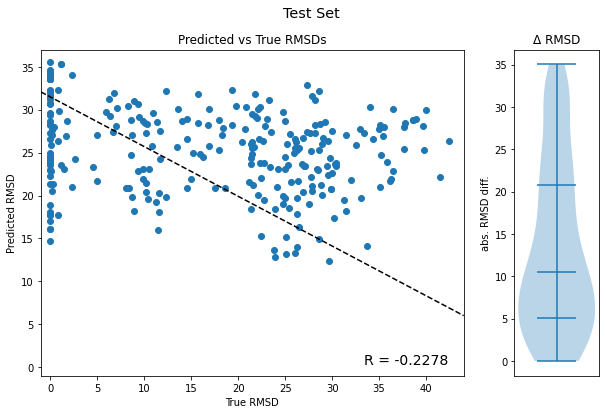

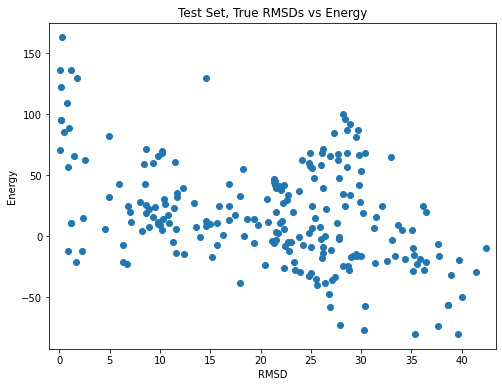

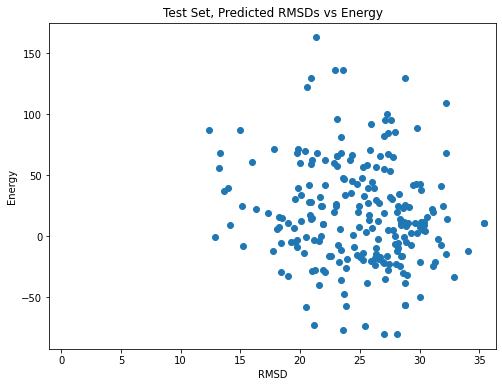

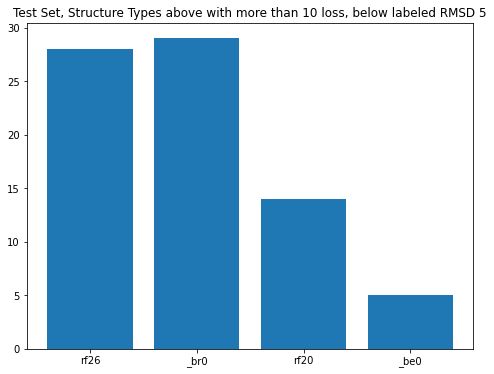

Prediction below 0: Label 0.1720, Pred -0.3615
Prediction below 0: Label 0.0000, Pred -0.4732
Prediction below 0: Label 0.0000, Pred -0.5785
Prediction below 0: Label 0.2310, Pred -0.5124
Prediction below 0: Label 0.1340, Pred -0.6321
Prediction below 0: Label 0.4430, Pred -0.7863
Prediction below 0: Label 0.1390, Pred -0.2810
Prediction below 0: Label 0.0000, Pred -0.6288
Prediction below 0: Label 0.0000, Pred -0.5135
Prediction below 0: Label 0.4480, Pred -0.1903
Prediction below 0: Label 1.7130, Pred -0.1240
Prediction below 0: Label 0.0000, Pred -0.0102
Prediction below 0: Label 0.0920, Pred -0.3553
Prediction below 0: Label 0.7690, Pred -0.1923
Prediction below 0: Label 0.0000, Pred -0.6558
Prediction below 0: Label 0.3800, Pred -0.3784
Prediction below 0: Label 0.0000, Pred -0.0276
Prediction below 0: Label 0.2490, Pred -0.5118
Prediction below 0: Label 0.2820, Pred -0.1121
Prediction below 0: Label 0.0000, Pred -0.2200
Prediction below 0: Label 0.3260, Pred -0.5735
Prediction be

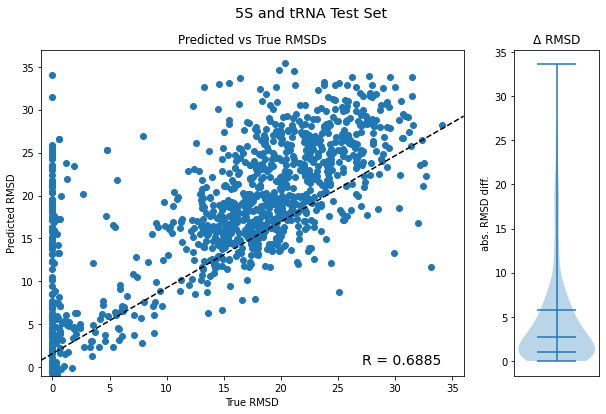

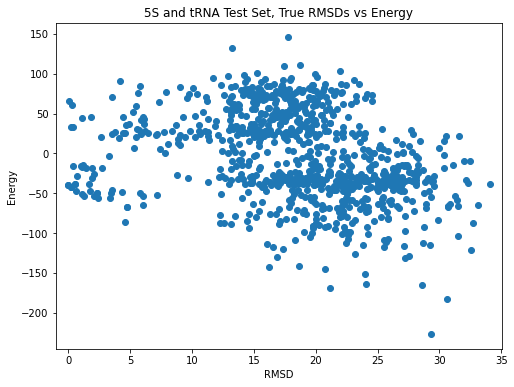

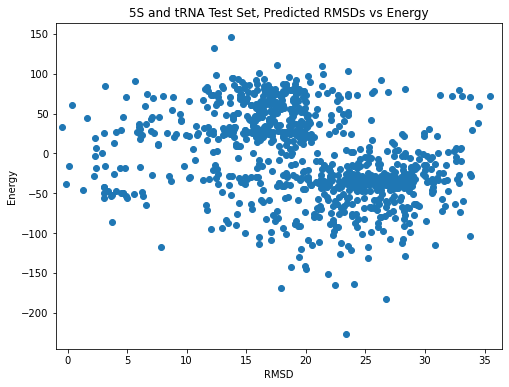

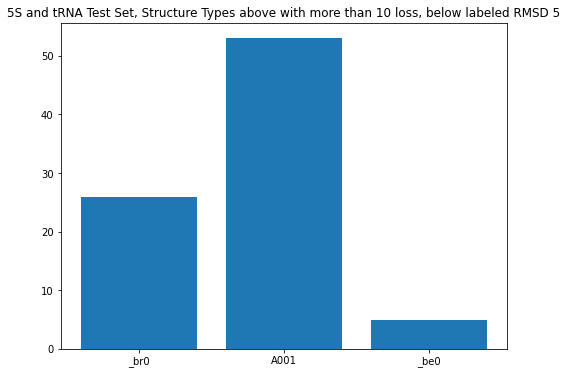

Prediction below 0: Label 0.0920, Pred -0.3553
Prediction below 0: Label 0.0920, Pred -0.3553
Prediction below 0: Label 0.0920, Pred -0.3553
Prediction below 0: Label 0.1570, Pred -0.0655
Training Set
Minimum Loss: Label = 34.3170, Prediction = 34.3167, Loss = 0.0000
Maximum Loss: Label = 13.0710, Prediction = 17.8468, Loss = 4.2758
Mean Test loss: 	 0.3520
Std. Dev. of Test loss:  0.5101
Min loss: 		 0.0000
First Quantile: 	 0.0314
Median: 		 0.1412
Third Quantile: 	 0.4516
Max Loss: 		 4.2758
LinregressResult(slope=0.9713853970623959, intercept=-0.038152235827578096, rvalue=0.9973541813254854, pvalue=0.0, stderr=0.002305652707053649, intercept_stderr=0.04707791224083692)


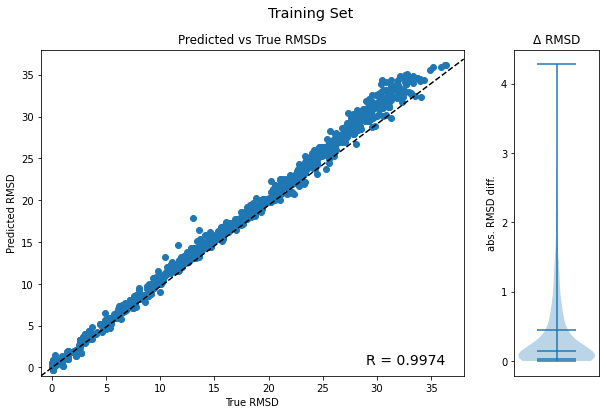

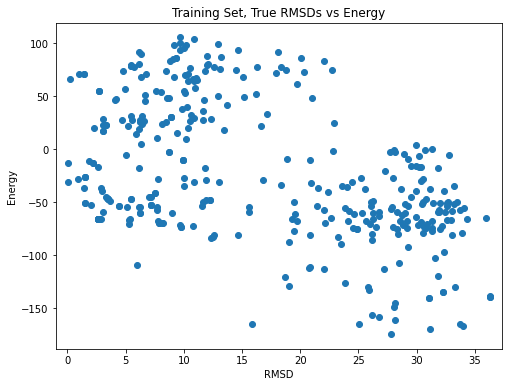

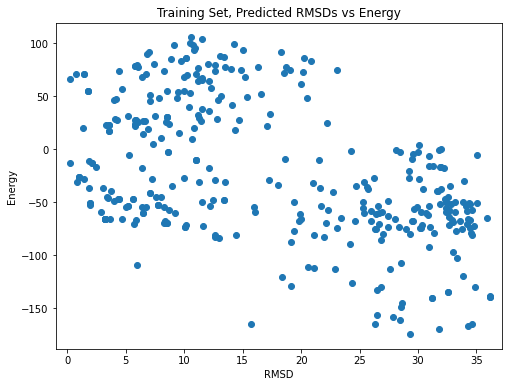

Validation Set
Minimum Loss: Label = 23.3240, Prediction = 23.2810, Loss = 0.0009
Maximum Loss: Label = 61.9850, Prediction = 19.4118, Loss = 42.0732
Mean Test loss: 	 11.9647
Std. Dev. of Test loss:  9.1516
Min loss: 		 0.0009
First Quantile: 	 4.6977
Median: 		 10.2459
Third Quantile: 	 17.0357
Max Loss: 		 42.0732
LinregressResult(slope=0.8501348095658668, intercept=3.2151594873232767, rvalue=0.27110109166607455, pvalue=4.234962837857256e-08, stderr=0.1520659983632399, intercept_stderr=3.6663177141893875)


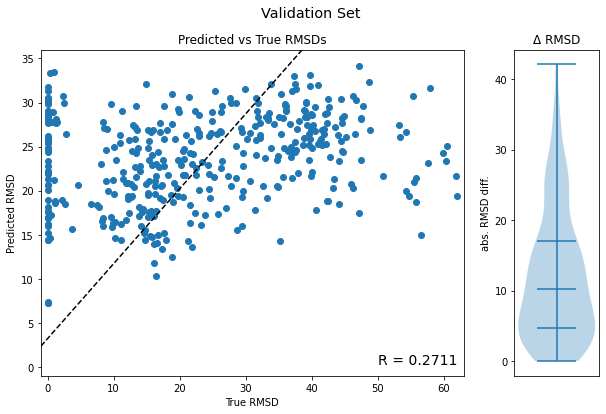

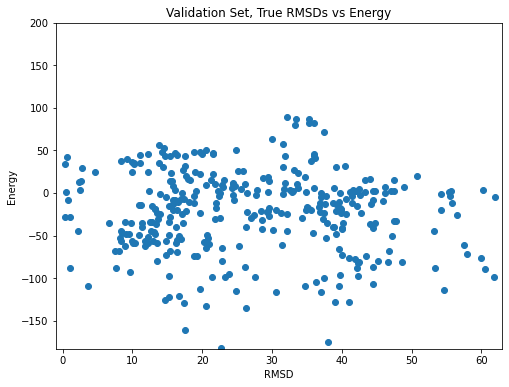

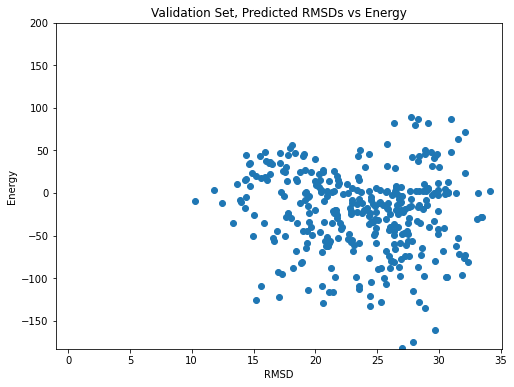

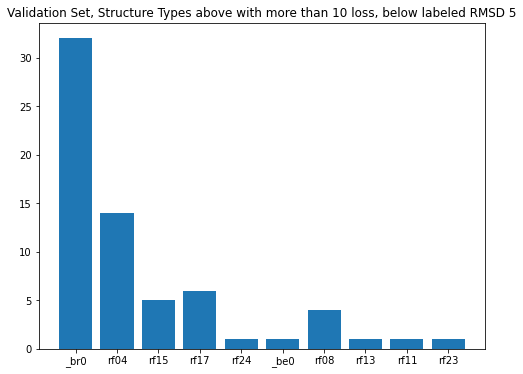

LinregressResult(slope=0.668947998996826, intercept=6.374862144478151, rvalue=0.43414939286012294, pvalue=1.4045627470330736e-69, stderr=0.035971115165506204, intercept_stderr=0.811749912471021)


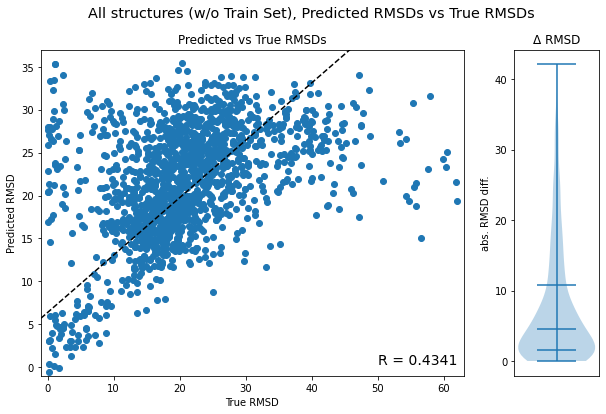

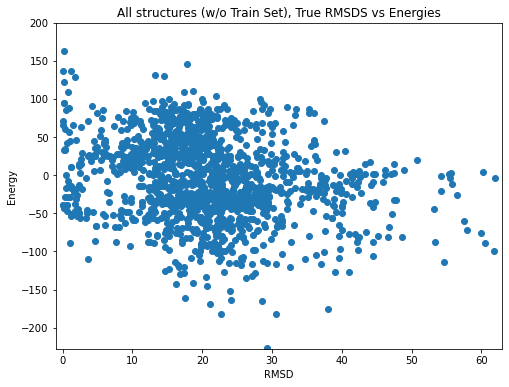

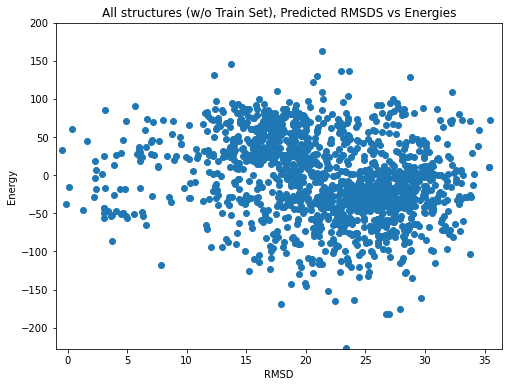

In [15]:
#Test
from run.utility import rmsd_scatter, e_rmsd_scatter

# loss cutoff for type histo
cutoff = [10, 5]

train_loader = DataLoader(training_dataset, batch_size=1)
val_loader = DataLoader(val_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)
st_test_dataloader = DataLoader(st_test_dataset, batch_size=1)

model.to(device)
checkpoint = th.load(f"{run_dir}/model_data/epoch_{select}.pth", map_location=device)
print(f"Using state dict from epoch {checkpoint['epoch']}")
model.load_state_dict(checkpoint["model_state_dict"])

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_list = "../data/test_energy.txt"
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_list = "../data/old_train_energy.txt"
    elif loader == train_loader:
        title = "Training Set"
        e_list = "../data/train_energy.txt"
    elif loader == val_loader:
        title = "Validation Set"
        e_list = "../data/val_energy.txt"
    en, trs, prs, tlosses = test(model, loader, title, device, e_list, cutoff)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

        

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

In [ ]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(figsize=(8, 6)) #layout='constrained',
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots( figsize=(8, 6)) #layout='constrained',
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")